# Capstone Project

General Assembly passion project. Scrape or obtain data from resources online to develop a dataset to perform cleaning, EDA, and analysis on. Try to predict a model on common themes like: 

- Price
- If item is in category A or B
- Cluster and create groups

- Predict lowest amount a shoe will sell for? So people know what price to wait for before buying?

### Part 1 - Gathering the raw data

In [6]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from time import sleep, strftime
import datetime
import ast
from os import listdir

np.random.seed(42)

pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 12 ms


In [7]:
# Retrieving information from API in json format from StockX.com
result = requests.get('https://stockx.com/api/browse?page=1&category=152')
json_res = result.json()
result = requests.get('https://stockx.com/api/browse?page=2&category=152')
json_res = result.json()

time: 1.87 s


In [8]:
# Functions to run for loop to scrape website.
def shoe_scraper(pages=50):
    '''Returns one dataframe of all results. And will save into a new file.'''
        # Have to run requests first to get appropriate column names
    req = requests.get('https://stockx.com/api/browse?page=1&category=152')
    json_req = req.json()
    df = pd.DataFrame([], columns=json_req['Products'][0].keys())

    for i in range(1,pages):
        try:
            html = 'https://stockx.com/api/browse?page=' + str(int(i)) + '&category=152'
            result = requests.get(html)
            json_res = result.json()
            df = pd.concat([df, pd.DataFrame(json_res['Products'])])
            sleep(0.5)
        except:
            break
    
    # Drop row duplicates
    df.drop_duplicates(['shortDescription', 'urlKey'], inplace=True) 
    
    # Function to save as csv file under today's day as raw (before dropping)
    def csv_maker(df):
        filename = 'StockX_' + strftime("%m%d%H")
        df.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\' + filename, encoding='utf-8')
    csv_maker(df)    
    return df

time: 14 ms


In [9]:
def clean_df(busy_dataframe):
    '''Dropping columns that hold little to no information. Combining columns with relevant info.
    Then reset the index since we are getting repeated indices'''
    # Market DataFrame. If scraping, comes in ready form.
    # If pulling from old data, dictionary comes in string form
    if isinstance(busy_dataframe.market.reset_index(drop=True)[0], str):
        # Change string to dictionary using ast library
        market_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['market']])
    else:
        market_df = pd.DataFrame([row for row in busy_dataframe['market']])
        
    # Same as above, but for including link for images
    if isinstance(busy_dataframe.media.reset_index(drop=True)[0], str):
        media_df = pd.DataFrame([ast.literal_eval(row) for row in busy_dataframe['media']])['thumbUrl']
    else:
        media_df = pd.DataFrame([row for row in busy_dataframe['media']])['imageUrl']
    
    # Combine dataframes and drop unnecessary columns
    cleaner_dataframe = busy_dataframe.join(market_df)
    cleaner_dataframe = cleaner_dataframe.join(media_df)    
    cleanest_dataframe = cleaner_dataframe.drop(['breadcrumbs', 'childId', 'countryOfManufacture', 'type', 
        'uuid', 'dataType', 'doppelgangers', 'condition', 'description', 'hidden', 'ipoDate', 'productCategory', 
        'shoeSize', 'urlKey', 'charityCondition', 'releaseTime', 'shortDescription', 'media', '_highlightResult', 
        'market', '_tags', 'id', 'objectID', 'lastHighestBidTime', 'lastLowestAskTime', 'styleId', 'productId',
        'productUuid', 'skuUuid', 'updatedAt', 'traits', 'tickerSymbol', 'salesLastPeriod',
        'minimumBid', 'averageDeadstockPriceRank', 'deadstockSoldRank', 'pricePremium', 'pricePremiumRank',
        'salesThisPeriod', 'createdAt', 'lastSaleDate'], axis=1)
    
    # Reset the index, since we are getting repeated indices
    cleanest_dataframe.reset_index(drop=True, inplace=True)    
    return cleanest_dataframe

time: 18 ms


In [73]:
## Web Scraper code. Commented out to focus on an unchanging data set.
# scraped_shoe = shoe_scraper()

time: 4 ms


In [14]:
def read_and_clean(path):
    '''Read a file path where datasets are stored. Cleans the dataframe by removing duplicates,
    removing first column (Unnamed: 0) to be ready for clean_df function.'''
    file_list = listdir(path)
    file_list.remove('dataio')
    file_list.remove('shoenumbers.pickle')
    file_list.remove('targetvars.pickle')
    file_list.remove('Final_Dataset')
    
    # Make a list of all the dataframes
    parts_df = [pd.read_csv('../datasets/' + files) for files in file_list]
    
    # Make one dataframe, take out first column and drop duplicates based on 'urlkey'
    df = pd.concat(parts_df)
    df = df.iloc[:,1:]
    df.drop_duplicates(['uuid'], inplace=True)#, keep='last')
    
    # Clean Brand names
    df.brand = df.brand.map(lambda x: x.title())
    
    # Lastly, change 'nan' to np.nan.
    df = df.applymap(lambda x: np.nan if x=='nan' else x)
    return df

time: 12 ms


In [15]:
# Using functions defined above to read all previously downloaded data into one dataframe.
path = '../datasets/'

shoe = clean_df(read_and_clean(path))

time: 3.61 s


In [16]:
shoe.to_csv(path_or_buf='C:\\Users\\Chris\\Desktop\\dsi-atl-3\\project\\Capstone\\datasets\\Final_Dataset', encoding='utf-8')

time: 87 ms


### Part 2 - Cleaning and Initial Analysis
Some initial cleaning and EDA will need to be done.
- Drop nulls
- Change time series into datetime if possible
- Check out the shape
- Drop the error value for the high bid > $20,000

**Make a metric for rarity: average Deadstock Price / retail Price**

In [5]:
# Some cleaning first. Take out null rows and change time data to date time
shoe.dropna(inplace=True)
shoe['releaseDate'] = pd.to_datetime(shoe.releaseDate).dt.date
shoe['year'] = pd.to_datetime(shoe.year.map(lambda x: str(int(x)))).dt.year
shoe.shape

(2050, 24)

time: 25 ms


In [6]:
# New metric for rarity of shoe & a boolean for those above median
shoe['rarity'] = shoe.averageDeadstockPrice/shoe.retailPrice
shoe['rarity_bool'] = shoe.rarity.map(lambda x: 1 if x >= shoe.rarity.median() else 0)

# Since shoes retailed at $0 doesn't fit into the scope of the project, drop them.
infinity_ind = shoe[shoe.retailPrice==0].index
shoe.drop(infinity_ind, axis=0, inplace=True)
shoe.reset_index(inplace=True, drop=True)

# Most 'rare' shoes
shoe[['name', 'colorway', 'retailPrice', 'averageDeadstockPrice', 'highestBid', 'rarity']].sort_values('rarity', ascending=False).head()

,name,colorway,retailPrice,averageDeadstockPrice,highestBid,rarity
1740,Supreme NY Black Cement (2002),Black/Black-Cement Grey,65.0,1388,1000,21.353846
1861,Momofuku,Dark Grey/White-Gum Light Brown,110.0,1706,1336,15.509091
1653,Ice Blue,Ice Blue/Vachetta Tan-White,140.0,1936,3037,13.828571
1862,Air Max Day 3.26,Sail / University Red,125.0,1706,1336,13.648000
1322,Tie Dye Black,Black/White-White,108.0,1447,1000,13.398148


time: 317 ms


(-5, 1500)

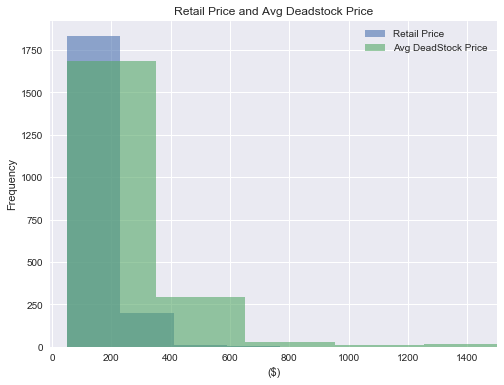

time: 291 ms


In [31]:
# Plots for general overview
fig = plt.figure(figsize=(8,6))
shoe.retailPrice.plot(kind='hist', alpha=0.6)
shoe.averageDeadstockPrice.plot(kind='hist', alpha=0.6)
plt.title('Retail Price and Avg Deadstock Price')
plt.legend(['Retail Price', 'Avg DeadStock Price'])
plt.xlabel('($)')
plt.xlim(-5, 1500)

In [8]:
# A view of the most expensive bid on shoe.
shoe[shoe.highestBid > 3000][['shoe', 'colorway', 'lastSale', 'highestBid', 'averageDeadstockPrice', 'retailPrice']].sort_values('highestBid', ascending=False)

,shoe,colorway,lastSale,highestBid,averageDeadstockPrice,retailPrice
1651,Adidas Ultra Boost,Adidas-Ultra-Boost-Miami-Hurricanes,2515,3037,1936,180.0
1652,Nike Air Max 90,White/White,2515,3037,1936,160.0
1653,Jordan 1 Retro Low OG,Ice Blue/Vachetta Tan-White,2515,3037,1936,140.0


time: 23 ms


In [9]:
# A view at the most highest retailed shoe. Strangely enough, it is not in the top 7 highest bid.
shoe[shoe.retailPrice == shoe.retailPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'averageDeadstockPrice']]

,shoe,colorway,name,retailPrice,year,averageDeadstockPrice
1697,Air Yeezy 2,Gold/White,John Geiger x LASCO Golden Child,1850.0,2016,250


time: 16 ms


In [10]:
# A look at the highest average deadstock price
shoe[shoe.averageDeadstockPrice == shoe.averageDeadstockPrice.max()][['shoe', 'colorway', 'name', 'retailPrice', 'year', 'averageDeadstockPrice']]

,shoe,colorway,name,retailPrice,year,averageDeadstockPrice
629,Adidas Yeezy Boost 750,Brown/Carbon White-Light Brown,OG Light Brown,350.0,2015,3059


time: 19 ms


### Part 3 - Subset data with top 3 brands and perform EDA
Scale the dataframe down so that not too many outside brands are taking the focus away from the main goal of the project.

In [11]:
# Concerned with only the top brands
topshoes = shoe[(shoe.brand=='Adidas')|(shoe.brand=='Nike')|(shoe.brand=='Jordan')]
topshoes.reset_index(drop=True, inplace=True)
# Have to redefine the rarity cut-off
topshoes['rarity_bool'] = topshoes.rarity.map(lambda x: 1 if x >= topshoes.rarity.median() else 0)
topshoes.shape

(1893, 26)

time: 267 ms


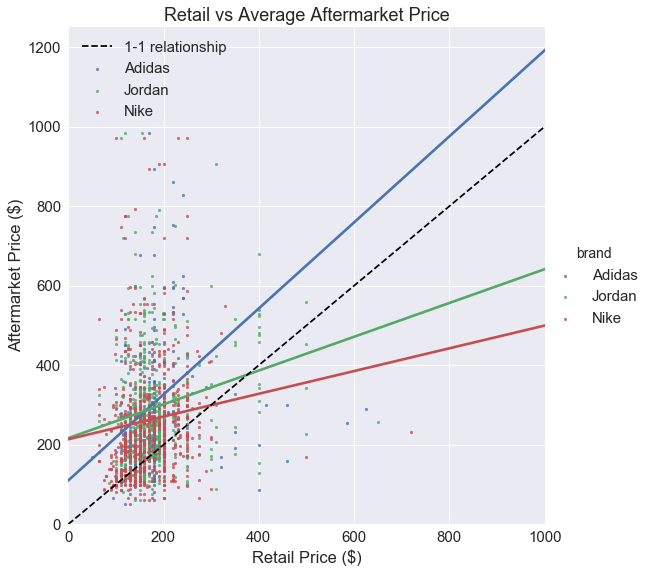

time: 426 ms


In [32]:
# See a 1-to-1 linear line for retail Price vs Aftermarket price
sns.set(font_scale=1.5)
sns.lmplot(x='retailPrice', y ='averageDeadstockPrice', data=topshoes, hue='brand', 
           fit_reg=True, size=8, scatter_kws={"s": 10}, ci=None)
plt.plot(np.linspace(0,2000,2000), np.linspace(0,2000,2000), linestyle='--', 
         color='black', label='1-1 relationship')
plt.xlim([0,1000])
plt.ylim([0,1250])
plt.title('Retail vs Average Aftermarket Price')
plt.xlabel('Retail Price ($)')
plt.ylabel('Aftermarket Price ($)')
plt.legend(loc='best')
plt.show()

In [84]:
import statsmodels.api as sm
xx = topshoes[['retailPrice', 'brand']]
yy = topshoes[['averageDeadstockPrice', 'brand']]

xx_Adidas, xx_Nike = xx[xx.brand=='Adidas'].retailPrice, xx[xx.brand=='Nike'].retailPrice
yy_Adidas, yy_Nike = yy[yy.brand=='Adidas'].averageDeadstockPrice, yy[yy.brand=='Nike'].averageDeadstockPrice
xx_Adidas = sm.add_constant(xx_Adidas)

model_adi = sm.OLS(yy_Adidas.values, xx_Adidas.values)
model_adi = model_adi.fit()
model_adi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     23.17
Date:                Thu, 13 Jul 2017   Prob (F-statistic):           2.00e-06
Time:                        13:20:11   Log-Likelihood:                -3327.9
No. Observations:                 474   AIC:                             6660.
Df Residuals:                     472   BIC:                             6668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.0779     40.984      2.686      0.007      29.545     190.611
x1             1.0819      0.225      4.814      0.000       0.640       1.523
==============================================================================
Omnibus:                      489.308   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18892.651
Skew:                           4.694   Prob(JB):                         0.00
Kurtosis:                      32.470   Cond. No.                         599.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

time: 43 ms


In [85]:
xx_Nike = sm.add_constant(xx_Nike)
model_nike = sm.OLS(yy_Nike.values, xx_Nike.values)
model_nike = model_nike.fit()
model_nike.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     10.47
Date:                Thu, 13 Jul 2017   Prob (F-statistic):            0.00127
Time:                        13:20:11   Log-Likelihood:                -5089.4
No. Observations:                 756   AIC:                         1.018e+04
Df Residuals:                     754   BIC:                         1.019e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.7436     16.742     12.767      0.000     180.877     246.610
x1             0.2860      0.088      3.236      0.001       0.113       0.460
==============================================================================
Omnibus:                      707.198   Durbin-Watson:                   1.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22868.781
Skew:                           4.286   Prob(JB):                         0.00
Kurtosis:                      28.544   Cond. No.                         429.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

time: 24 ms


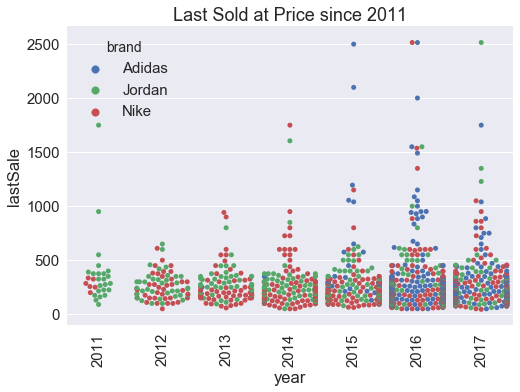

time: 35.9 s


In [86]:
sns.swarmplot(x='year', y='lastSale', data=topshoes[topshoes.year>2010], hue='brand')
plt.xticks(rotation=90)
plt.title('Last Sold at Price since 2011')
plt.show()

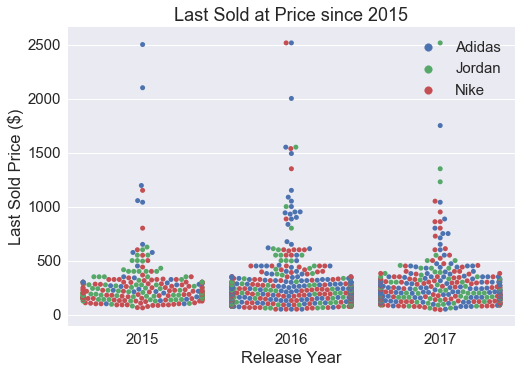

time: 32.2 s


In [87]:
# Adidas didn't really come into the market until 2015. Let's look more closely
sns.swarmplot(x='year', y='lastSale', data=topshoes[topshoes.year>2014], hue='brand')
plt.legend(loc='best')
plt.xlabel('Release Year')
plt.ylabel('Last Sold Price ($)')
plt.title('Last Sold at Price since 2015')
plt.show()

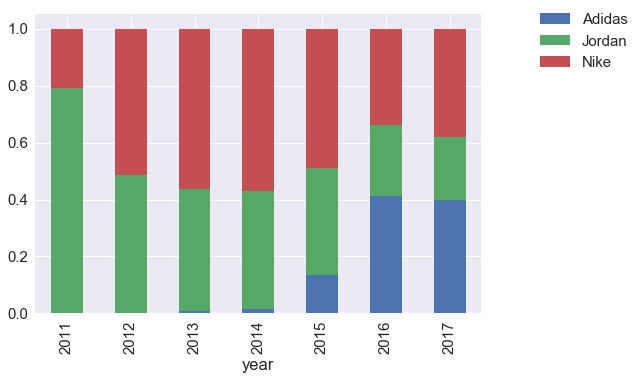

time: 212 ms


In [88]:
# Did Adidas increase market share (on StockX) in pure number of listings?
sub_tops = topshoes[topshoes.year>2010].groupby(['year', 'brand'])['brand'].count().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

sub_tops.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

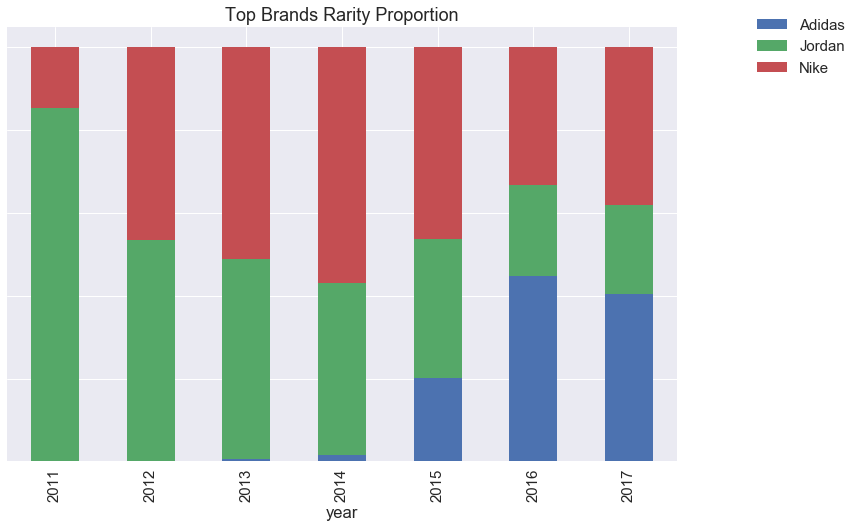

time: 318 ms


In [89]:
# Did Adidas increase in terms of sneakerhead influence, measured by sum of rarity?
sub_tops = topshoes[topshoes.year>2010].groupby(['year', 'brand'])['rarity'].sum().unstack().fillna(0)
sub_tops = sub_tops.T
sub_tops = sub_tops.div(sub_tops.sum())
sub_tops = sub_tops.T

fig, ax = plt.subplots(figsize=(12,8))
sub_tops.plot(kind='bar', stacked=True, ax=ax)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Top Brands Rarity Proportion')
ax.set_yticklabels([])
plt.show()

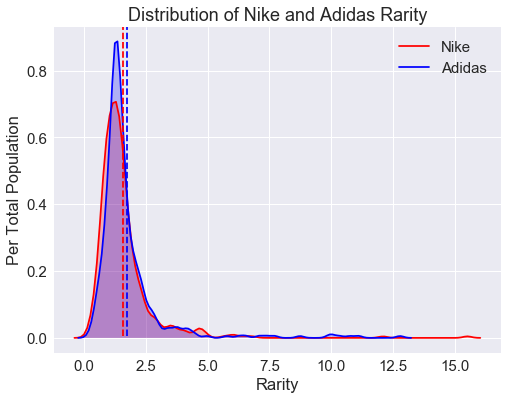

time: 248 ms


In [90]:
import scipy.stats as stats
#H0 - The average rarity of Adidas is the same as the average rarity of Nike since 2015
#H1 - The average rarity of Adidas is NOT the same as the average rarity of Nike since 2015
# threshold -> 5%
nike_rarity = topshoes[(topshoes.year>=2015) & (topshoes.brand=='Nike')].rarity
adidas_rarity = topshoes[(topshoes.year>=2015) & (topshoes.brand=='Adidas')].rarity

fig = plt.figure(figsize=(8,6))

sns.kdeplot(nike_rarity, color='red', shade=True, legend=False)
sns.kdeplot(adidas_rarity, color='blue', shade=True, legend=False)
plt.axvline(x=nike_rarity.mean(), ymin=0.05, c='r', ls='--')
plt.axvline(x=adidas_rarity.mean(), ymin=0.05, c='b', ls='--')
# plt.xlim([0,5])
plt.legend(['Nike', 'Adidas'])
plt.xlabel('Rarity')
plt.ylabel('Per Total Population')
plt.title('Distribution of Nike and Adidas Rarity')

In [91]:
stats.ttest_ind(nike_rarity, adidas_rarity)
# p < 0.05. So we reject the null hypothesis that the averages are the same. They are
# in fact different. Statistically, Adidas has a higher average rarity since 2015.

Ttest_indResult(statistic=-1.9671840904328324, pvalue=0.049445189804579535)

time: 4 ms


## Part 4 - Natural Language Processing & Modeling


In [12]:
# NLP
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer

# Metrics & Preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV

time: 5.01 s


In [13]:
# Going to make a copy of the dataframe in case any changes are made later on
tops = topshoes.copy()
# Maybe the colorway is an indicator of rarity
snow = SnowballStemmer('english')
# placeholder = pd.Series('Colorway_token')
placeholder = pd.Series(tops.colorway.apply(lambda x: x.replace("/"," ").replace('-',' ').split(" ")))

tops['colorway_token'] = placeholder.apply(lambda x: " ".join([snow.stem(y) for y in x]))

time: 195 ms


In [14]:
baseline = max(1 - tops.rarity_bool.mean(), tops.rarity_bool.mean())
print baseline

0.500264131009
time: 4 ms


In [308]:
# Going to try several vectorizers and models. Better to write a function that will do this in one step.
def tokenize_test(text, vect, model):
    '''Arguments are text, vect, model, target will be rarity_bool for this section.'''
    X = tops[text]
    y = tops['rarity_bool']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
    X_train_dtm = vect.fit_transform(X_train)    
    X_test_dtm = vect.transform(X_test)
    model.fit(X_train_dtm, y_train)
    y_pred_class = model.predict(X_test_dtm)
    return accuracy_score(y_test, y_pred_class)

# Making a function to make a dataframe for the accuracy results of tokenize_test
def accuracy_df_maker(models, vectors, texts, last_df=False):
    '''Models and vectors are dictionarys with key as the label and value as the object.
    Texts is a list of features to test on. Returns a sorted dataframe with accuracy scores
    of every model, vectorizer, and feature combination. Will add previous dataframe if present.'''
    Accuracy_scores = []
    for model_k, model_v in models.items():
        for vect_k, vect_v in vectors.items():
            for text in texts:
                Accuracy_scores.append((model_k, vect_k, text, tokenize_test(text, vect_v, model_v)))
    
    df = pd.DataFrame(Accuracy_scores, columns=['Model', 'Vectorizer', 'Feature', 'Accuracy_score'])
    
    if isinstance(last_df,pd.DataFrame):
        df = pd.concat([last_df, df])
    
    return df.sort_values('Accuracy_score', ascending=False).reset_index(drop=True)

time: 20 ms


In [309]:
# Parameter set up
ng =(1,2)
cvec, hvec, tvec = CountVectorizer(ngram_range=ng), HashingVectorizer(ngram_range=ng), TfidfVectorizer(ngram_range=ng)
models = {'SVC':SVC(), 'Log':LogisticRegression(), 'Bernoulli':BernoulliNB(), 'KNN':KNeighborsClassifier()}
vectors = {'CVEC':cvec, 'HVEC':hvec, 'TVEC': tvec}
texts = ['colorway_token', 'category', 'title', 'name']
# Function run
nlp = accuracy_df_maker(models, vectors, texts)

time: 5.53 s


In [311]:
# Separate functions because random forest with hashing takes more than 3 minutes with worse results.
# Same with Multinomial. Combining all into one dataframe, nlp_df
models2 = {'Random Forest':RandomForestClassifier(), 'Multinomial':MultinomialNB()}
vectors2 = {'CVEC':cvec, 'TVEC':tvec}
nlp2 = accuracy_df_maker(models2, vectors2, texts, last_df=nlp)

time: 2.02 s


In [312]:
# Trying bagging and boosting. Again hashing takes too long and doesn't increase score by much. So taking out.
# Model Set up
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
bagger = BaggingClassifier(dtree, max_samples=1.0, max_features=1.0)
booster = AdaBoostClassifier(dtree, n_estimators=50, learning_rate=1.0)
# Parameter setup
models3 = {'Bagger':bagger, 'Booster':booster}
df = accuracy_df_maker(models3, vectors2, texts, last_df=nlp2)

time: 28.1 s


In [313]:
print 'Baseline:', baseline
df[df.Accuracy_score > baseline*1.15]

Baseline: 0.500264131009


,Model,Vectorizer,Feature,Accuracy_score
0,Random Forest,TVEC,category,0.591029
1,Multinomial,CVEC,category,0.591029
2,Bernoulli,TVEC,category,0.585752
3,Bernoulli,CVEC,category,0.585752
4,Multinomial,TVEC,category,0.585752
5,Log,HVEC,category,0.580475
6,Random Forest,CVEC,category,0.580475
7,KNN,HVEC,title,0.580475
8,KNN,CVEC,colorway_token,0.577836
9,Bagger,TVEC,category,0.577836


time: 34 ms


In [335]:
# Look at the features in one of the models 
# Top performing at the time multinomial/cvec/category with acc of 0.59
X, y  = tops.category, tops.rarity_bool
Xtr, Xte, ytr, yte = train_test_split(X, y, train_size = .8, random_state=42)
Xtr_dtm = cvec.fit_transform(Xtr)
mnb = MultinomialNB()
mnb.fit(Xtr_dtm, ytr)
mnb_df = pd.DataFrame(zip(np.exp(mnb.feature_log_prob_.flatten()), cvec.get_feature_names()),columns=['prob', 'features'])
mnb_df['abs'] = mnb_df.prob.abs()
mnb_df.sort_values('abs', ascending=False).reset_index(drop=True).head()

,prob,features,abs
0,0.088550,air,0.088550
1,0.072194,jordan,0.072194
2,0.072194,air jordan,0.072194
3,0.053582,adidas,0.053582
4,0.040891,other,0.040891


time: 49 ms


In [103]:
# Trying to finetune models to achieve better accuracy scores
X = tops.title
y = tops.rarity_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)

X_train_dtm = tvec.fit_transform(X_train)
X_test_dtm = tvec.transform(X_test)

log_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}
lr_gridsearch = GridSearchCV(LogisticRegression(), log_params, cv=5, verbose=1)
lr_gridsearch.fit(X_train_dtm, y_train)
lr_dict = lr_gridsearch.best_params_
print lr_dict

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'penalty': 'l2', 'C': 0.038535285937105271, 'solver': 'liblinear'}
time: 5.11 s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.9s finished


In [104]:
logreg = LogisticRegression(C=lr_dict['C'], penalty=lr_dict['penalty'], solver=lr_dict['solver'])
logreg.fit(X_train_dtm, y_train)
print accuracy_score(y_test, logreg.predict(X_test_dtm)), df.iloc[0,-1]

0.55672823219 0.591029023747
time: 16 ms


In [105]:
# Trying to do PCA on these word vectors to achieve better score:
from sklearn.decomposition import TruncatedSVD

X = tops.category
y = tops.rarity_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
X_train_dtm = cvec.fit_transform(X_train)
X_test_dtm = cvec.transform(X_test)

svd = TruncatedSVD(n_components=50)
svd_words = svd.fit_transform(X_train_dtm)

logreg.fit(svd_words, y_train)
svd_pred_df = pd.DataFrame(logreg.predict(svd.transform(X_test_dtm)))

print accuracy_score(y_test, svd_pred_df.iloc[:,:])
# Due to randomness, results show values from 0.53 to 0.60, which would fall on the top half of model performance

0.577836411609
time: 152 ms


## Part 5 - Clustering

In [18]:
cv_color = CountVectorizer(max_features=20, stop_words=['core'], ngram_range=(1,2))
all_colors = cv_color.fit_transform(tops.colorway_token)
color_df = pd.DataFrame(all_colors.todense(), columns=cv_color.get_feature_names())

time: 38 ms


In [19]:
#### Dummy variables ####
# Change brand to 0, 1, 2
# Change category based on words [Yeezy, NMD, Air Jordan, Ultra Boost, Adidas/Nike Other, 
# Air Max, Iniki, Air Force, Foamposite, LeBron, KD, Nike SB, Kobe, Nike Basketball/Other]
# Change colorway based on color spectrum colors (color_df.columns)

tops.brand = tops.brand.astype('category').cat.codes

category_list = ['Yeezy', 'NMD', 'Air Jordan', 'Ultra Boost', 'adidas Other', 'Nike Other', 'Air Max',
                'Iniki', 'Air Force', 'Foamposite', 'LeBron', 'KD', 'Nike SB', 'Kobe', 'Nike Basketball']
for cat in category_list:
    tops[cat] = tops.category.map(lambda x: 1 if cat.lower() in x.lower() else 0)
    
color_list = list(color_df.columns)    
for color in color_list:
    tops[color] = tops.colorway_token.map(lambda x: 1 if color.lower() in x.lower() else 0)
    
# Change all spaces to _ in column names
tops.columns = tops.columns.str.replace(' ','_')

time: 90 ms


---

# Do clustering with colors/category/colors&category

---

In [20]:
col_list = tops.loc[:,'Yeezy':].columns
mat_string = ' + '.join(col_list)
mat_string

u'Yeezy + NMD + Air_Jordan + Ultra_Boost + adidas_Other + Nike_Other + Air_Max + Iniki + Air_Force + Foamposite + LeBron + KD + Nike_SB + Kobe + Nike_Basketball + black + black_black + black_white + blue + dark + gold + green + grey + light + metal + metal_gold + metal_silver + navi + red + silver + univers + varsiti + varsiti_red + white + white_black'

time: 7 ms


In [21]:
import patsy
other_var = '''retailPrice + absChangePercentage + annualHigh + annualLow + averageDeadstockPrice + 
deadstockRangeHigh + deadstockRangeLow + brand + deadstockSold + highestBid + lastSale + lowestAsk + 
salesLast72Hours + volatility + rarity - 1'''
matrix_string = 'category ~ ' + other_var + ' + ' + mat_string

y_cluster, X_cluster = patsy.dmatrices(matrix_string, tops)

time: 331 ms


In [22]:
from sklearn.cluster import DBSCAN, KMeans
ss = StandardScaler()
Xs = ss.fit_transform(X_cluster)

db = DBSCAN(eps=5, min_samples=20)
db.fit(Xs)

print pd.Series(db.labels_).unique()
print 'Not in a class %:', list(db.labels_).count(-1)/float(len(tops)) * 100
print 'In first class %:', list(db.labels_).count(0)/float(len(tops)) * 100
print 'In remaining classes %:', 100 - (list(db.labels_).count(-1)/float(len(tops)) * 100 + list(db.labels_).count(0)/float(len(tops)) * 100)
print '------------------------'
print 'Last label count:', list(db.labels_).count(pd.Series(db.labels_).unique()[-1])

tops['cluster_label'] = pd.Series(db.labels_)

[-1  0  1  2  3  4  5  6  9  7  8]
Not in a class %: 23.6661384046
In first class %: 55.6259904913
In remaining classes %: 20.7078711041
------------------------
Last label count: 43
time: 723 ms


In [23]:
# KMeans
km = KMeans(n_clusters=6, random_state=42)
km.fit(Xs)
pd.Series(km.labels_).unique()

print pd.Series(km.labels_).value_counts()

tops['cluster_label'] = pd.Series(km.labels_)

0    970
1    630
3    120
5    109
2     48
4     16
dtype: int64
time: 131 ms


## Part 6 - Predicting Rarity (regression and classification)

In [24]:
# Now have a bunch more variables. Would be a good idea to do PCA on the features to avoid multicollinearity.
num_df = tops.drop(['cluster_label','retailPrice', 'averageDeadstockPrice', 'releaseDate', 
                    'category', 'colorway', 'name', 'shoe', 'title', 'thumbUrl', 
                    'colorway_token', 'deadstockRangeHigh', 'deadstockRangeLow', 'rarity',
                   'rarity_bool'], axis=1).copy()

# Make another dataframe that doesn't include any colors or names to see if all those dummy variable creation mattered.
no_extra_df = num_df.loc[:,:'volatility'].copy()

time: 8 ms


In [25]:
def setup(dropped_col=False, target='rarity', regression=True):
    if dropped_col:
        X = no_extra_df.drop(dropped_col,axis=1)
    else:
        X = no_extra_df
    if regression:
        y = tops[target]
    else:
        y = tops.rarity_bool
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, random_state=42)
    Xs = ss.fit_transform(X_train)
    Xst = ss.transform(X_test)
    
    return Xs, Xst, y_train, y_test

time: 10 ms


In [26]:
from sklearn.pipeline import Pipeline, FeatureUnion

Xs, Xst, y_train, y_test = setup()
ss = StandardScaler()
pca = PCA(svd_solver='full')
combined_features = FeatureUnion([('ss',ss), ('pca', pca)])
linreg_ = LinearRegression()
lin_pipeline = Pipeline([('features', combined_features), ('linreg',linreg_)])

# # Commented out to save on processing time
# lin_param = {
#     'features__pca__n_components':np.arange(len(no_extra_df.columns))
# }
# gs_lin = GridSearchCV(lin_pipeline,param_grid=lin_param, cv=10)
# gs_lin.fit(Xs, y_train)
# best_lin_params = gs_lin.best_params_['features__pca__n_components']

best_lin_params = 10 # for reproducibility
print 'Best number of PC for linear pipeline:', best_lin_params
# Linear regression with PCA
lin_pipeline.set_params(features__pca__n_components=best_lin_params)
lin_pipeline.fit(Xs, y_train)
lin_pipeline.score(Xst, y_test)

Best number of PC for linear pipeline: 10


0.86049311186525357

time: 59 ms


In [27]:
# Even though gridsearch returned 10. Changing PCA to 3 doesn't affect original score much.
# This is proven again in a cross-val score of the test data, where score for 3 PC is higher.
print '3 PC', np.mean(cross_val_score(linreg_, pca.transform(Xst)[:,:3], y_test, cv=10))
print '10 PC', np.mean(cross_val_score(linreg_, pca.transform(Xst)[:,:], y_test, cv=10))

3 PC 0.7828780236
10 PC 0.780848117847
time: 57 ms


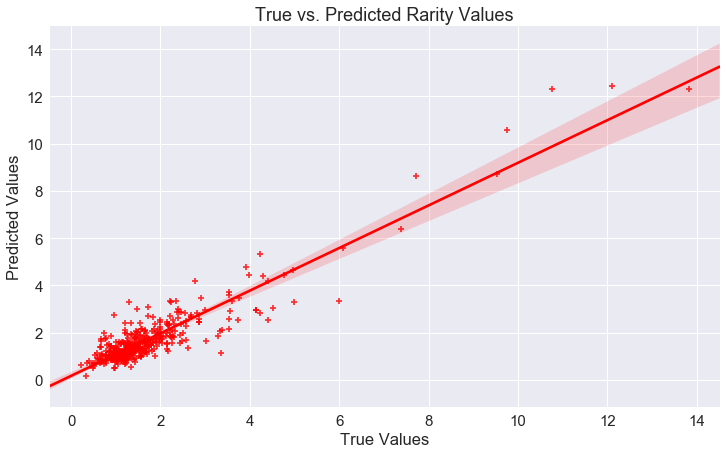

time: 315 ms


In [35]:
y_pred = lin_pipeline.predict(Xst)

fig, ax = plt.subplots(figsize=(12,7))
sns.regplot(y_test, y_pred, marker='+', color='r', scatter_kws={"s": 30}, ax=ax)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Rarity Values')

In [286]:
# Linear regression without PCA
lr_ = LinearRegression()
lr_.fit(Xs, y_train)
print lr_.score(Xst, y_test)
lr_df = pd.DataFrame(zip(lr_.coef_, no_extra_df.columns), columns=['Coef', 'Features'])
lr_df.reindex(lr_df.Coef.abs().sort_values(ascending=False).index).head()

0.860493111865


,Coef,Features
10,0.483620,lowestAsk
4,0.448522,annualLow
6,-0.443875,changeValue
9,0.403756,lastSale
5,0.219361,changePercentage


time: 20 ms


In [288]:
# Logistic Regression with PCA
Xs, Xst, y_train, y_test = setup(regression=False)
log_pipeline = Pipeline([('features', combined_features), ('logreg', LogisticRegression())])

#Commented out to save on processing time
# log_param = {
#     'features__pca__n_components':np.arange(len(no_extra_df.columns)),
#     'logreg__penalty':['l1','l2'],
#     'logreg__solver':['liblinear'],
#     'logreg__C':np.logspace(-5,0,20)
# }
# gs_log = GridSearchCV(log_pipeline, param_grid=log_param, cv=10)
# gs_log.fit(Xs, y_train)
# log_pca = gs_log.best_params_['features__pca__n_components']
# log_penalty = gs_log.best_params_['logreg__penalty']
# log_solver = gs_log.best_params_['logreg__solver']
# log_C = gs_log.best_params_['logreg__C']

## for reproducibility
log_pca = 0 
log_penalty = 'l1'
log_solver = 'liblinear'
log_C = 1.0
print 'Best number of PC for logistic pipeline:', log_pca
log_pipeline.set_params(features__pca__n_components=log_pca, 
                        logreg__penalty=log_penalty,
                        logreg__solver=log_solver,
                        logreg__C=log_C)
log_pipeline.fit(Xs, y_train)
print log_pipeline.score(Xst, y_test)
logpca_coef = log_pipeline.get_params()['logreg'].coef_

Best number of PC for logistic pipeline: 0
0.796833773087
time: 44 ms


In [289]:
# Non-PCA logistic regression
log_pipeline.set_params(features__pca__n_components=None,
                        logreg__penalty=log_penalty,
                        logreg__solver=log_solver,
                        logreg__C=log_C)
log_pipeline.fit(Xs, y_train)
print 'Mean Accuracy with no PCA:', log_pipeline.score(Xst, y_test)

Mean Accuracy with no PCA: 0.79419525066
time: 36 ms


In [290]:
# Getting only the top coefficients from the logistic regression
coef_df = pd.DataFrame(zip(no_extra_df.columns, logpca_coef.flatten()), columns=['Feature', 'Coefficients'])
coef_df['abs'] = abs(coef_df.Coefficients).copy()
coef_df = coef_df.sort_values('abs', ascending=False).reset_index(drop=True)
coef_df.head()

,Feature,Coefficients,abs
0,lastSale,2.498825,2.498825
1,annualLow,1.199845,1.199845
2,changeValue,-1.065582,1.065582
3,lowestAsk,0.421813,0.421813
4,annualHigh,0.368260,0.368260


time: 16 ms


In [291]:
# Using only the top few coefficients as features
top_features = ['annualLow', 'changeValue', 'lowestAsk']
bot_features = [e for e in coef_df.Feature if e not in top_features]
Xs, Xst, y_train, y_test = setup(dropped_col=bot_features, 
                                 target='lastSale', regression=True)
lin_pipeline.set_params(features__pca__n_components=None)
lin_pipeline.fit(Xs, y_train)
lin_pipeline.score(Xst, y_test)

0.91816578944793636

time: 20 ms


In [268]:
linr_coef = lin_pipeline.get_params()['linreg'].coef_
lr_coef_df = pd.DataFrame(zip(no_extra_df.drop(bot_features, axis=1).columns, 
                              linr_coef.flatten()), columns=['Feature', 'Coefficients'])
lr_coef_df['abs'] = abs(lr_coef_df.Coefficients).copy()
lr_coef_df.sort_values('abs', ascending=False, inplace=True)
lr_coef_df.reset_index(drop=True)

,Feature,Coefficients,abs
0,lowestAsk,63.636320,63.636320
1,annualLow,38.890209,38.890209
2,changeValue,25.523654,25.523654


time: 16 ms


## Part 7 - Image Processing

The code below is for image processing using Keras and Tensorflow. Unfortunately, these libraries don't play nicely with Windows. As a result, a virtual machine was used in another notebook. The forked repository is an extension of the deep learning repository by github user *[nirmalyaghosh](https://github.com/nirmalyaghosh/deep-learning-vm)*.

Imaging code adapted from *[source1](https://pythonprogramming.net/automated-image-thresholding-python/?completed=/thresholding-python-function/)* and *[source2](http://pillow.readthedocs.io/en/3.4.x/reference/Image.html)*. Finally, pickling code was sourced from *[stackoverflow](https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict)*.

The code to transfer data is below in markdown mode for reading convenience. The rest of the code can be found at *[my github](https://github.com/chrisk447/deep-learning-vm/blob/master/notebooks/Capstone%20Image%20Processing.ipynb)*.

    # only gathering images for those that have images. (As of 7/7/2017)
    import pickle
    import urllib3
    from PIL import Image
    import io

    tops_with_pics = tops[tops.thumbUrl != '']
    tops_with_pics.reset_index(drop=True, inplace=True)

    # Interpreting the image as data and preparing it to be pickled.
    pickled_array = []
    counter = 0
    for shoe_num in range(len(tops_with_pics)):
        fd = urllib.urlopen(tops_with_pics.thumbUrl[shoe_num])
        image_file = io.BytesIO(fd.read())
        i = Image.open(image_file).convert('RGB')
        iar = np.asarray(i)
        iar.setflags(write=1)

        pickled_array.append(iar)
        sleep(0.5)
        image_file.close()
        fd.close()

    # Pickling the feature data into the deep learning repository
    with open('../../../keras/deep-learning-vm/notebooks/shoenumbers.pickle', 'wb') as handle:
        pickle.dump(pickled_array, handle, protocol=2)

    # Pickling the target data into the deep learning repository
    with open('../../../keras/deep-learning-vm/notebooks/targetvars.pickle', 'wb') as handle2:
        pickle.dump(tops_with_pics.rarity_bool.values, handle2, protocol=2)